# data

## loading data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!wget -d --header="Authorization:3_20220425211734_2bb87c77214078c4b35d37c9_8f51243ee31ba055214814012e680b5e19881ebd_002_20220425221734_0027_dnld" https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10a.tar.bz2

In [ ]:
#!tar -xjvf "/content/RML2016.10a.tar.bz2" -C "/content/gdrive/MyDrive/RML2016.10a" 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_pickle("/content/gdrive/MyDrive/RML2016.10a/RML2016.10a_dict.pkl")

In [ ]:
d = pd.DataFrame(df.keys())
snrs,mods = d[1].unique() , d[0].unique().tolist()

In [ ]:
snrs,mods = d[0].unique() , d[1].unique().tolist()

In [ ]:
X = []  
label = []
for key , value in df.items():
    label.extend([key]*value.shape[0])
    X.append(value)
X = np.vstack(X)


## make label into one-hot

In [ ]:
from tensorflow.keras.utils import to_categorical
## if using snr and mod toghether as train 
#encoded_1 = to_categorical([i for i in range(len(mods)*len(snrs))])
encoded = to_categorical([i for i in range(len(mods))])


In [ ]:
def mods_to_one_hot (inp):
    return encoded[mods.index(inp)]

In [ ]:
mods_to_one_hot(mods[2])

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y = [lbl for lbl in label]

## partition data

In [ ]:
from sklearn.model_selection import train_test_split
y = label 
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.4, random_state=42)

y_test_SNR = np.array([lbl[1] for lbl in y_test]) 
y_train = np.array([mods_to_one_hot(lbl[0]) for lbl in y_train]).astype('float64')
y_test  = np.array([mods_to_one_hot(lbl[0]) for lbl in y_test]).astype('float64')
X = X.astype('float64')

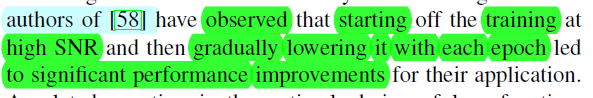

### in case to follow this condition

In [ ]:
y = label 
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.4, random_state=42)

SNR_train = np.array([lbl[1] for lbl in y_train])
y_train = np.array([mods_to_one_hot(lbl[0]) for lbl in y_train])
y_test  = np.array([mods_to_one_hot(lbl[0]) for lbl in y_test])

sorted_arg_SNR_descended = SNR_train.argsort()[::-1]
X_train = X_train[sorted_arg_SNR_descended]
y_train = y_train[sorted_arg_SNR_descended]


X = X.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [ ]:
print( X_train.shape, y_train.shape)

(132000, 2, 128) (132000, 11)


# Network

## Define Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Reshape,Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K

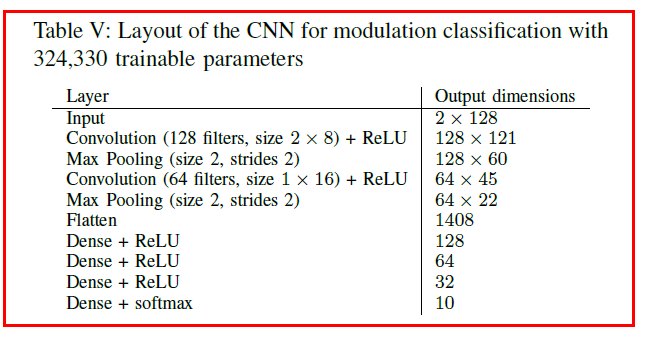

In [ ]:
def CNN_model_article(input_shape,output_shape):

    input_signal = Input(shape = input_shape)
    reshape = Reshape((2,128,1))(input_signal)
    conv_1 = Conv2D(128 , kernel_size = (2, 8), activation='relu' )(reshape)
    max_pool_1 = MaxPooling2D (pool_size=(1,2), strides = 2,data_format ='channels_last')(conv_1)
    
    conv_2 = Conv2D(64, kernel_size =(1, 16), activation='relu')(max_pool_1)
    max_pool_2 = MaxPooling2D (pool_size=(1,2), strides = 2)(conv_2)

    flatten = Flatten()(max_pool_2)

    dense_1 = Dense(128, activation='relu')(flatten)
    dense_2 = Dense(64, activation='relu')(dense_1)
    dense_3 = Dense(32, activation='relu')(dense_2)
    dense_4 = Dense(output_shape, activation='softmax')(dense_3)

    return Model(inputs = input_signal, outputs = dense_4)

model = CNN_model_article(X_train[0].shape , y_train[0].shape[0])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 128)]          0         
                                                                 
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 121, 128)       2176      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 60, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 45, 64)         131136    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 22, 64)        0         
 2D)                                                         

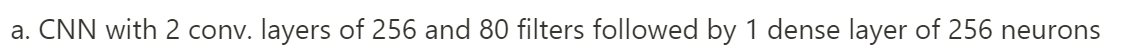

In [ ]:
def CNN_model_on_email(input_shape,output_shape):

    input_signal = Input(shape=input_shape)
    reshape = Reshape((2,128,1))(input_signal)
    conv_1 = Conv2D(256, kernel_size =(2, 8), activation='relu')(reshape)
    conv_2 = Conv2D(80, kernel_size =(1, 16), activation='relu')(conv_1)
    flatten = Flatten()(conv_2)

    dense_1 = Dense(256, activation='relu')(flatten)
    dense_4 = Dense(output_shape, activation='softmax')(dense_1)

    return Model(inputs = input_signal, outputs = dense_4)

model = CNN_model_on_email(X_train[0].shape , y_train[0].shape[0])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 128)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 121, 256)       4352      
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 106, 80)        327760    
                                                                 
 flatten_1 (Flatten)         (None, 8480)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2171136   
                                                                 
 dense_5 (Dense)             (None, 11)                2827

## Train on gpu

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
model = CNN_model_on_email(X_train[0].shape , y_train[0].shape[0])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)  

In [ ]:
filepath = "/content/gdrive/MyDrive/RML2016.10a"
with tf.device('/device:GPU:0'):
    model = CNN_model_on_email(X_train[0].shape , y_train[0].shape[0])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss= tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )  
    history = model.fit(X_train,y_train,
              validation_data=(X_test, y_test),
              callbacks = [
                    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')],
              epochs=20, batch_size=1024, verbose=2 )

Epoch 1/20
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/RML2016.10a/assets
129/129 - 25s - loss: 2.1048 - accuracy: 0.2166 - val_loss: 1.8793 - val_accuracy: 0.3056 - 25s/epoch - 191ms/step
Epoch 2/20
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/RML2016.10a/assets
129/129 - 23s - loss: 1.7933 - accuracy: 0.3227 - val_loss: 1.7636 - val_accuracy: 0.3272 - 23s/epoch - 177ms/step
Epoch 3/20
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/RML2016.10a/assets
129/129 - 23s - loss: 1.6943 - accuracy: 0.3647 - val_loss: 1.6563 - val_accuracy: 0.3812 - 23s/epoch - 177ms/step
Epoch 4/20
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/RML2016.10a/assets
129/129 - 23s - loss: 1.5945 - accuracy: 0.4094 - val_loss: 1.5483 - val_accuracy: 0.4291 - 23s/epoch - 176ms/step
Epoch 5/20
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/RML2016.10a/assets
129/129 - 23s - loss: 1.4988 - accuracy: 0.4428 - val_loss: 1.4652 - val_accuracy: 0.4485 - 23s

In [ ]:
model.save("/content/gdrive/MyDrive/RML2016.10a")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/RML2016.10a/assets


In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/RML2016.10a')

In [ ]:
history.history['loss']

AttributeError: ignored

https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb

# Plot the outputs

In [ ]:
import matplotlib.pyplot as plt

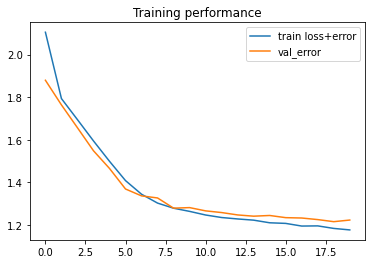

In [ ]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

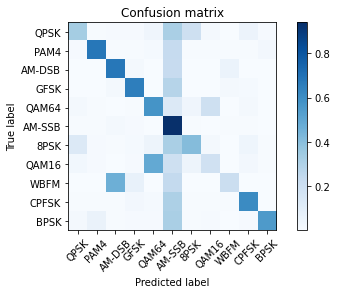

In [ ]:
# Plot confusion matrix
classes = mods
test_Y_hat = model.predict(X_test, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

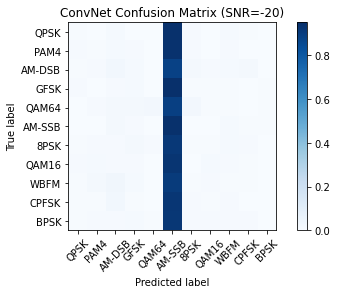

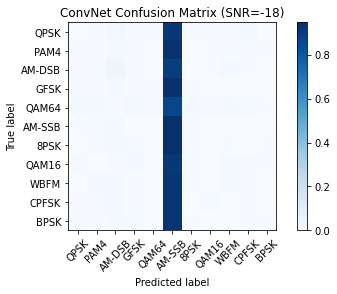

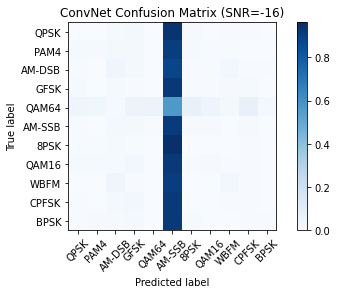

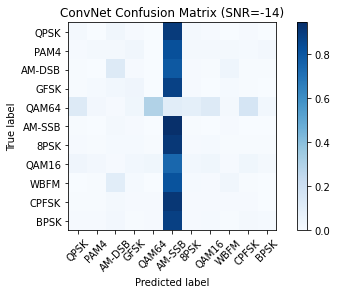

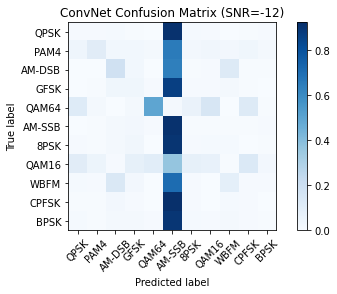

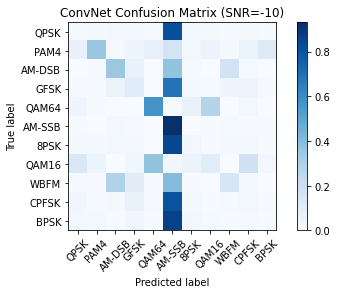

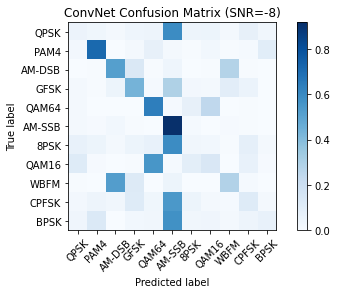

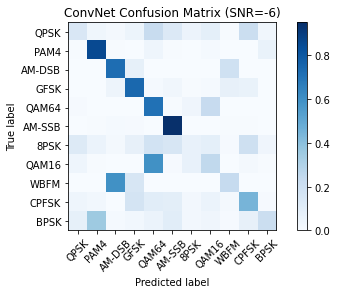

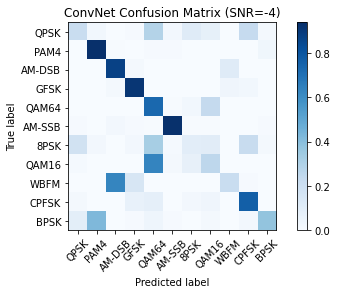

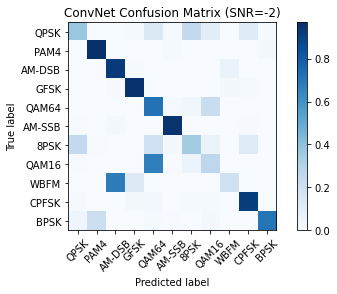

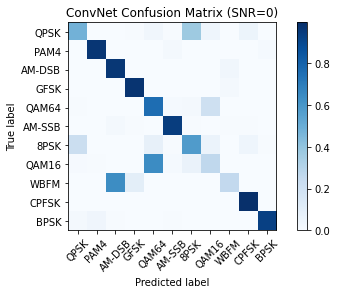

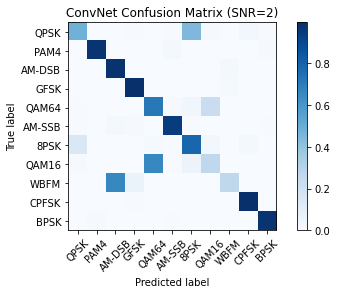

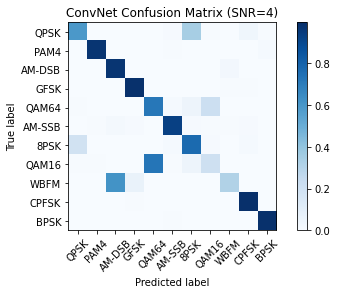

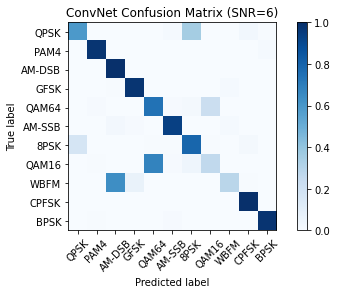

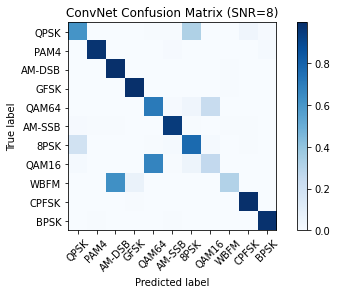

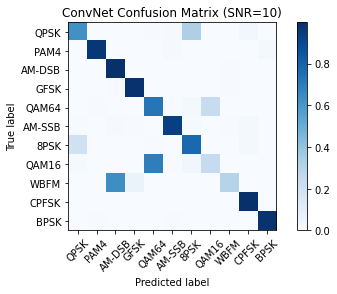

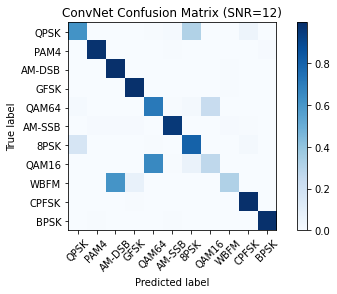

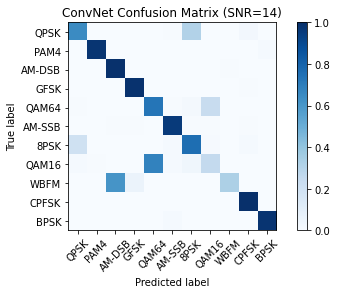

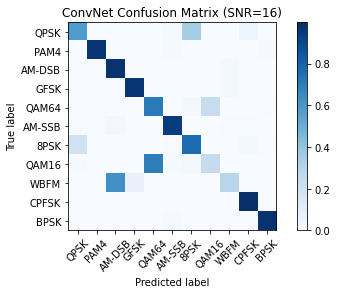

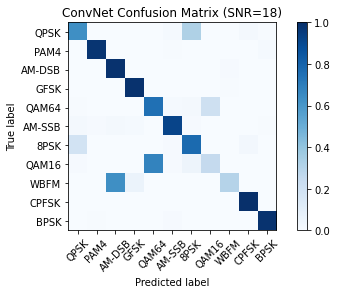

In [ ]:
# Plot confusion matrix
acc = {}
for snr in np.sort(snrs):

    # extract classes @ SNR
    test_SNRs = y_test_SNR
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor

    acc[snr] = 1.0*cor/(cor+ncor)